In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import copy
import random
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
from resources.helper import PeakData, Isotopes
known_cys_fnam = 'resources/known_cys_labeled.tab'
known_gln_fnam = 'resources/known_gln_labeled.tab'
blacklist_fnam = 'resources/blacklist.tab'

# Read isotope information into an object:
IUPAC_atomic_masses = 'resources/IUPAC-atomic-masses.csv'
IUPAC_atomic_abundances = 'resources/IUPAC-atomic-abundances.html'
isotope_obj = Isotopes(IUPAC_atomic_masses, IUPAC_atomic_abundances)

# Adducts:
adducts_fnam = 'resources/adducts.tab'

## Define default parameters for peak filtering and peak pair finding

In [5]:
params = {
    ### Specify the formula for the isotopes in the labels used ###
    'labels': {
        'cys': '[13]C3 [15]N',
        'gly': '[13]C2',
        'gln': '[13]C5'
    },
    # End of isotope specification ################################

    ### Peak filter parameters ###
    'min_area': 6000,         # minimum peak area for at least one sample
    'min_area_label': 6000,   # minimum peak area for at least one labelled sample
    'min_MW': 120,            # minimum molecular weight of a compound (120 is one Da below Cysteine)
    'min_fold_blank': 4,      # minimum sample to blank peak area ratio
                              # i.e. max(sample)/max(blank) > min_fold_blank

    # Peak filter: peak merging #
    # Merge peaks within a ppm mass distance AND within
    # a retention time difference OR a retention time difference x2
    # AND over a minimum peak area correlation coefficient
    'merge_ppm_tol': 50,      # maximum mass distance (in ppm) between peaks to merge
    'merge_RT_tol': 0.1,      # maximum retention time difference between peaks to merge
    'merge_corr_tol':0.9,     # minimum peak area correlation coefficient
    # End of peak filter #########
    
    ### Peak pair finding ###
    'pair_ppm_tol': 10,            # maximum mass distance (in ppm) of expected mass shift between pairs
    'pair_RT_tol': 0.25,           # maximum retention time difference between pairs
    'pair_min_area': 1,            # minimum number of sample that pass the area ratio criterium

    # Range, or list of ranges, of labelled to unlabelled peak area ratios
    # within the accepted cutoff (ratio = labelled / sum(labelled, unlabelled))
    # These ratios are adjusted on an experiment-to-experiment basis (see below examples).
    'area_ratio_cutoff': {
        'cys': ((0.2, 0.28),
                (0.34, 0.42)),  # GSSG theoretical parent/(parent+heavy) is 0.25 with 50/50 labelled
        'gly': ((0.08, 0.24),),
        'gln': ((0.18, 0.6),),
    },
    # End of pair finding ###
    
    ### Peak pair filter parameters ###
    # Pair filter: adduct flagging #
    # Flag an adduct if it is within a ppm mass distance
    # and within a retention time difference
    # and has smaller total peak area than its parent ion
    'adduct_ppm_tol': 200,     # maximum mass distance (in ppm) to call adduct
    'adduct_RT_tol': 0.8,      # maximum retention time difference to call adduct

    # Pair filter: isotope flagging #
    # Flag an isotope if it is within a ppm mass distance
    # and within a retention time difference
    # and has a minimum peak area correlation coefficient
    # and has smaller total peak area than its parent ion
    'isotope_ppm_tol': 200,     # maximum mass distance (in ppm) to call isotope
    'isotope_RT_tol': 0.4,      # maximum retention time difference to call isotope
    'isotope_corr_tol':0.7,     # minimum peak area correlation coefficient to call isotope
    # End of peak pair filter #########

}

# Calculate the mass shift for each label:
params['MW_shift'] = dict()
for label in params['labels']:
    params['MW_shift'][label] = isotope_obj.isotopes2mass_shift(params['labels'][label])
print('Calculated mass shift for entered labels:')
pp.pprint(params['MW_shift'])

Calculated mass shift for entered labels:
{'cys': 4.007099400040005,
 'gln': 5.016774176699997,
 'gly': 2.0067096706799994}


## Cysteine and glutamine tracing on three cancer cell lines

In this dataset three cancer cell lines were used for tracing: B16F10, HCT116 and HUH-7.

Cells were seeded on 6-well plates and at ~50 % confluency media was swapped to contain either vehicle, label or drug:
1. Vehicle
2. 50/50 labelled/unlabelled cystine
3. 50/50 labelled/unlabelled glutamine
4. 10 uM BSO (glutahione synthesis inhibitor)

After 24 hours metabolites were harvested by removing the media, washing once with cold saline and extracing metabolites using 80 % methanol.
Each condition was repeated to make replicates and the BSO treated extract was split in two, with one half recieving a spike-in of purified glutathione equivalent to the expected depletion of glutathione by the BSO treatment.
This spike-in sample can be used to discriminate glutahione ionization adducts from those biologically produced.
For example a glutathione ionization adduct will decrease upon BSO treatment, becuase glutathione levels fall, but will increase again in the spike-in samples.
On the contrary, succinylglutathione is biologically produced from glutathione and fumarate.
It is depleted upon BSO treatment but not rescued by glutathione spike-in.

In addition to these samples a set of blanks were made.
Solvent blanks were made from the extraction solvent.
Extraction blanks were made by performing metabolite extracting on a well without cells.

In [6]:
# Excel data filenames:
datafile_pos = 'projects/three-cell-lines/pos/three-cell-lines_cys-gln-tracing_pos.xlsx'
datafile_neg = 'projects/three-cell-lines/neg/three-cell-lines_cys-gln-tracing_neg.xlsx'

# Input information:
input_desc_fnam = 'projects/three-cell-lines/three-cell-lines.json'
# Since comments are not allowed in JSON format
# Use the eval function to turn this pseudo JSON into a dictionary:
input_desc = eval(open(input_desc_fnam, 'r').read())

# Read the data:
peak_obj = PeakData('three-cell-lines_cys-gln_tracing', input_desc, params)

# Read peaks:
peak_obj.read_peaks(datafile_pos, 'pos')
peak_obj.read_peaks(datafile_neg, 'neg')

# Annotate known peaks:
peak_obj.annotate_known_peaks(known_cys_fnam, isotope_obj.formula2mass)

Running peak filtering for polarity: pos
Filtered 17750 peaks out based on.
Minimum peak area: 12127
Minimum molecular weight: 156
Minimum fold over blank: 4718
Merged closely related peaks: 749
10446 peaks left.

Running peak filtering for polarity: neg
Filtered 4930 peaks out based on.
Minimum peak area: 3086
Minimum molecular weight: 59
Minimum fold over blank: 1198
Merged closely related peaks: 587
8075 peaks left.



### Adjust parameters for peak pair finding

In [7]:
# Find labelling ratio for known glutamine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_gln_fnam, 'pos', isotope_obj.formula2mass, 'gln', ['m', 'm+5'])

,GSH (m),GSH (m+5),GSSG (m),GSSG (m+5),Glutamine (m),Glutamine (m+5),S-Lactoylglutathione (m),S-Lactoylglutathione (m+5),S-(Formylmethyl)glutathione (m),S-(Formylmethyl)glutathione (m+5),Succinylglutathione (m),Succinylglutathione (m+5)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.706353,0.293647,0.501986,0.498014,0.748492,0.251508,0.778366,0.221634,0.964771,0.035229,0.781599,0.218401
std,0.044330,0.044330,0.063667,0.063667,0.195165,0.195165,0.122729,0.122729,0.011219,0.011219,0.068100,0.068100
min,0.670363,0.226351,0.450537,0.384438,0.602936,0.000114,0.604656,0.084939,0.947687,0.020679,0.681427,0.109230
25%,0.677589,0.265359,0.456110,0.477296,0.619647,0.089589,0.705748,0.120872,0.959749,0.028727,0.764236,0.200284
50%,0.683349,0.316651,0.480547,0.519453,0.636041,0.363959,0.777983,0.222017,0.965193,0.034807,0.774097,0.225903
75%,0.734641,0.322411,0.522704,0.543890,0.910411,0.380353,0.879128,0.294252,0.971273,0.040251,0.799716,0.235764
max,0.773649,0.329637,0.615562,0.549463,0.999886,0.397064,0.915061,0.395344,0.979321,0.052313,0.890770,0.318573


Notice that the minimum glutamine m+5 fraction is very low.
Upon inspection it appears to be a problem specific for the B16F10 samples.
However, since the problem seems to be isolated to glutamine no futher change were made.

In [8]:
# Find labelling ratio for known glutamine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_gln_fnam, 'neg', isotope_obj.formula2mass, 'gln', ['m', 'm+5'])

,GSH (m),GSH (m+5),GSSG (m),GSSG (m+5),Glutamine (m),Glutamine (m+5),S-Lactoylglutathione (m),S-Lactoylglutathione (m+5),S-(Formylmethyl)glutathione (m),S-(Formylmethyl)glutathione (m+5)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.720994,0.279006,0.504919,0.495081,0.585309,0.414691,0.497761,0.502239,0.689876,0.310124
std,0.048921,0.048921,0.089037,0.089037,0.106959,0.106959,0.119584,0.119584,0.060470,0.060470
min,0.683473,0.207522,0.407442,0.366646,0.493585,0.277878,0.308545,0.399623,0.627538,0.201145
25%,0.686734,0.244808,0.445491,0.433301,0.502242,0.322466,0.428448,0.422813,0.651230,0.301098
50%,0.695582,0.304418,0.479349,0.520651,0.542336,0.457664,0.552600,0.447400,0.684518,0.315482
75%,0.755192,0.313266,0.566699,0.554509,0.677534,0.497758,0.577187,0.571552,0.698902,0.348770
max,0.792478,0.316527,0.633354,0.592558,0.722122,0.506415,0.600377,0.691455,0.798855,0.372462


In [9]:
# Based on above analysis the m+5 ratio cutoff is chosen.
peak_obj.params['area_ratio_cutoff']['gln'] = ((0.05, 0.70),)

In [10]:
# Find labelling ratio for known cysteine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_cys_fnam, 'pos', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),S-(Formylmethyl)glutathione (m),S-(Formylmethyl)glutathione (m+4),G3P Cys (m),G3P Cys (m+4),Cysteine (m),Cysteine (m+4),DHAP Cys (m),DHAP Cys (m+4),G6P Cys (m),G6P Cys (m+4),Succinylcysteine (m),Succinylcysteine (m+4),Succinylglutathione (m),Succinylglutathione (m+4),Conjugate EC = C3H3O2 (m),Conjugate EC = C3H3O2 (m+4),Sulfinic glutathione (m),Sulfinic glutathione (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4),GSH conjugate EC = C4H10NO (m),GSH conjugate EC = C4H10NO (m+4)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.0
mean,0.563285,0.436715,0.541440,0.458560,0.497320,0.502680,0.529526,0.470474,0.808538,0.191462,0.707472,0.292528,0.808538,0.191462,0.578696,0.421304,0.713830,0.286170,0.732478,0.267522,0.609646,0.390354,0.572935,0.427065,0.562166,0.437834,0.5,0.5
std,0.010652,0.010652,0.096637,0.096637,0.080836,0.080836,0.147446,0.147446,0.024534,0.024534,0.099690,0.099690,0.024534,0.024534,0.064307,0.064307,0.064384,0.064384,0.057698,0.057698,0.149537,0.149537,0.022523,0.022523,0.017468,0.017468,0.0,0.0
min,0.551807,0.420360,0.405714,0.332617,0.385640,0.412349,0.286555,0.333315,0.784538,0.148575,0.568654,0.141116,0.784538,0.148575,0.511486,0.328042,0.600183,0.227215,0.632779,0.215735,0.475055,0.185855,0.545853,0.397491,0.536003,0.416328,0.5,0.5
25%,0.557511,0.430252,0.478374,0.402726,0.439804,0.442412,0.461923,0.355100,0.794377,0.182687,0.654863,0.250419,0.794377,0.182687,0.526524,0.381896,0.696847,0.238504,0.708669,0.229054,0.484127,0.272952,0.555435,0.410542,0.555002,0.424870,0.5,0.5
50%,0.558938,0.441062,0.556010,0.443990,0.510581,0.489419,0.561115,0.438885,0.799759,0.200241,0.708527,0.291473,0.799759,0.200241,0.571921,0.428079,0.724166,0.275834,0.753753,0.246247,0.565330,0.434670,0.572043,0.427957,0.559858,0.440142,0.5,0.5
75%,0.569748,0.442489,0.597274,0.521626,0.557588,0.560196,0.644900,0.538077,0.817313,0.205623,0.749581,0.345137,0.817313,0.205623,0.618104,0.473476,0.761496,0.303153,0.770946,0.291331,0.727048,0.515873,0.589458,0.444565,0.575130,0.444998,0.5,0.5
max,0.579640,0.448193,0.667383,0.594286,0.587651,0.614360,0.666685,0.713445,0.851425,0.215462,0.858884,0.431346,0.851425,0.215462,0.671958,0.488514,0.772785,0.399817,0.784265,0.367221,0.814145,0.524945,0.602509,0.454147,0.583672,0.463997,0.5,0.5


In [11]:
# Find labelling ratio for known cysteine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_cys_fnam, 'neg', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),S-(Formylmethyl)glutathione (m),S-(Formylmethyl)glutathione (m+4),G6P Cys (m),G6P Cys (m+4),Succinylcysteine (m),Succinylcysteine (m+4),Succinylglutathione (m),Succinylglutathione (m+4),Conjugate EC = C3H3O2 (m),Conjugate EC = C3H3O2 (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.572853,0.427147,0.880939,0.119061,0.596296,0.403704,0.539176,0.460824,0.650114,0.349886,0.654810,0.345190,0.509071,0.490929,0.516176,0.483824
std,0.012563,0.012563,0.128598,0.128598,0.036196,0.036196,0.122463,0.122463,0.054375,0.054375,0.050157,0.050157,0.013609,0.013609,0.145430,0.145430
min,0.556872,0.410746,0.633000,0.015839,0.539460,0.362047,0.415952,0.236359,0.568727,0.268206,0.597395,0.288734,0.490837,0.476107,0.237551,0.338428
25%,0.563090,0.419038,0.873625,0.053779,0.581102,0.377560,0.465224,0.443352,0.632566,0.326489,0.609619,0.303829,0.498594,0.480081,0.521390,0.422261
50%,0.574192,0.425808,0.931510,0.068490,0.596730,0.403270,0.519724,0.480276,0.644043,0.355957,0.659359,0.340641,0.511258,0.488742,0.549321,0.450679
75%,0.580962,0.436910,0.946221,0.126375,0.622440,0.418898,0.556648,0.534776,0.673511,0.367434,0.696171,0.390381,0.519919,0.501406,0.577739,0.478610
max,0.589254,0.443128,0.984161,0.367000,0.637953,0.460540,0.763641,0.584048,0.731794,0.431273,0.711266,0.402605,0.523893,0.509163,0.661572,0.762449


In [12]:
# Based on above analysis the cutoff is chosen:
peak_obj.params['area_ratio_cutoff']['cys'] = ((0.05, 0.70),)

# RT and MW tolerances are also adjusted:
peak_obj.params['pair_ppm_tol'] = 3
peak_obj.params['pair_RT_tol'] = 0.5

### Search for peak pairs and flag isotopes, adducts etc

In [13]:
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')

In [14]:
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')

In [15]:
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
pp.pprint(isotope_set)

{('[13]C',): {'abundance': 0.010599999999999998,
              'mass_shift': 1.0033548353399997},
 ('[13]C', '[13]C'): {'abundance': 0.00011235999999999996,
                      'mass_shift': 2.0067096706799994},
 ('[13]C', '[13]C', '[13]C'): {'abundance': 1.1910159999999995e-06,
                               'mass_shift': 3.010064506020001},
 ('[13]C', '[13]C', '[34]S'): {'abundance': 4.9045139999999985e-06,
                               'mass_shift': 4.00250550813999},
 ('[13]C', '[15]N'): {'abundance': 4.022699999999999e-05,
                      'mass_shift': 2.000389729360002},
 ('[13]C', '[15]N', '[34]S'): {'abundance': 1.7559085499999997e-06,
                               'mass_shift': 3.996185566820003},
 ('[13]C', '[17]O'): {'abundance': 4.065099999999999e-06,
                      'mass_shift': 2.00757197203},
 ('[13]C', '[18]O'): {'abundance': 2.1676999999999996e-05,
                      'mass_shift': 3.007599828220002},
 ('[13]C', '[2]H'): {'abundance': 1.5369999999999

In [16]:
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')

The samples have been labelled with both cystine and glutamine.
Both trace into glutathione and it's derivatives.
Thus, it is usefull to know which peak pairs are found
for both labels.

In [17]:
# Flag the label intersection:
peak_obj.flag_labels()

In [18]:
# Write results as Excel files:
peak_obj.write_pairs('projects/three-cell-lines/pos/three-cell-lines_cys-gln-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/three-cell-lines/neg/three-cell-lines_cys-gln-tracing_pairs_neg', 'neg')

### Processing the results

At this point, all the results have been written to Excel files which provide an interface to further processing/filtering/plotting.

In the following, I will show another way of processing the results and show some of the findings that can be extracted from the data.

In [19]:
# Extract sample information from the input description JSON
# stored in the "group" tag:
name2info = {desc['name']: desc for desc in input_desc.values() if desc['type'] != 'blank'}
sample_info_df = pd.DataFrame.from_dict(name2info, orient='index')
sample_info_df[['Cell_line','Treatment']] = sample_info_df.group.str.split(', ', expand=True)
sample_info_df.head(4)

,name,order,type,label,group,Cell_line,Treatment
B16_vec_1,B16_vec_1,1,sample,None,"B16F10, Vehicle",B16F10,Vehicle
B16_BSO_1,B16_BSO_1,7,sample,None,"B16F10, BSO",B16F10,BSO
B16_Cys_1,B16_Cys_1,3,sample,cys,"B16F10, Cys",B16F10,Cys
B16_Gln_1,B16_Gln_1,5,sample,gln,"B16F10, Gln",B16F10,Gln


In [20]:
# We start in positive polarity by grabbing the peak pairs from cystine tracing:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos.head(4)

,pair_id,MW_parent,RT_parent,MW_heavy,RT_heavy,polarity,label,name,RT_diff,MW_ppm_diff,Label_set,Isotopes,Adducts,Blacklist,known_anno,B16_vec_1,B16_vec_2,B16_Cys_1,B16_Cys_2,B16_Gln_1,B16_Gln_2,B16_BSO_1,B16_BSO_2,B16_BSO_GSH-AB_1,B16_BSO_GSH-AB_2,HCT116_vec_1,HCT116_vec_2,HCT116_Cys_1,HCT116_Cys_2,HCT116_Gln_1,HCT116_Gln_2,HCT116_BSO_1,HCT116_BSO_2,HCT116_BSO_GSH-AB_1,HCT116_BSO_GSH-AB_2,HUH7_vec_1,HUH7_vec_2,HUH7_Cys_1,HUH7_Cys_2,HUH7_Gln_1,HUH7_Gln_2,HUH7_BSO_1,HUH7_BSO_2,HUH7_BSO_GSH-AB_1,HUH7_BSO_GSH-AB_2
0,"((121.01988, 8.626), (125.02709, 8.621), pos, ...",121.02,8.626,125.027,8.621,pos,cys,Cysteine,0.005,0.913899,cys,None,"[(145, M+3H)]",None,Cysteine,3289,3416.65,3502.25,3802.48,3100.25,3113.58,3067.26,3252.22,7520.4,3094.7,20872.4,29798.7,9347.14,16258.3,8852.81,23428.9,40516.9,50972.7,45864,62086.1,1865.2,1887.71,1919.78,1828.98,1709.48,1803.33,1604.17,1641.06,2782.43,1610.52
1,"((123.10496, 2.261), (127.11236, 2.464), pos, ...",123.105,2.261,127.112,2.464,pos,cys,NaN,0.203,2.44182,cys,None,None,None,None,2300.86,2487.51,19560.3,1682.29,3657.04,6873.61,3175.18,4712.72,5859.27,9518.89,3402.81,4586.02,6273.98,10089,29777.2,7406.01,2625.94,2858.97,4735.07,8793.88,43756.6,29922.5,12436.6,25127.5,10823.7,10036.4,2827.78,8629.88,8095.81,19289.4
2,"((123.10499, 2.72), (127.11236, 2.464), pos, cys)",123.105,2.72,127.112,2.464,pos,cys,NaN,0.256,2.19812,cys,None,None,None,None,23223.2,18922.2,16021.7,19794.6,14338.8,15069.3,13056.7,41215.6,16289.6,26411.4,22442.9,24807.1,20384.6,35471.7,25075.3,32702.8,16156.7,25334.3,18785.3,28040.2,27175.1,33281.9,25823.1,46188,44455.2,28382.1,55938.5,43695,59837,39068.3
3,"((125.04782, 9.962), (129.05504, 9.871), pos, ...",125.048,9.962,129.055,9.871,pos,cys,3-Hydroxyaminophenol,0.091,0.964431,cys,None,"[(65, M+H+Na)]",None,None,1726.17,6651.57,8931.28,984.772,10873.8,12597.1,1246.81,4478.83,11370.1,6175.17,899.693,941.542,913.134,966.003,1054.84,1081.71,862.098,909.338,936.735,1014.85,426.196,395.396,367.315,355.383,449.685,391.076,232.556,557.212,1860.26,1580.24


In [21]:
def flat_df(df_pol, sample_info_df):
    # Now let's get rid of the adducts, isotopes and blacklisted peaks:
    mask = (df_pol['Isotopes'].isnull() & df_pol['Adducts'].isnull() & df_pol['Blacklist'].isnull()) | ~df_pol['known_anno'].isnull()
    df_pol = df_pol[mask]

    # And flatten the data for easy sorting/filtering/plotting:
    df_pol_flat = pd.melt(df_pol, id_vars=['MW_parent', 'RT_parent', 'Adducts', 'Label_set', 'known_anno'], value_vars=list(name2info.keys()), var_name='sample', value_name='area')
    # Add MW_RT string:
    df_pol_flat['MW_RT_anno'] = [str(mw)+'_'+str(rt)+'_'+str(anno) for mw, rt, anno in zip(df_pol_flat['MW_parent'].values, df_pol_flat['RT_parent'].values, df_pol_flat['known_anno'].values)]
    # Add sample info:
    df_pol_flat = df_pol_flat.merge(sample_info_df.loc[:, ['name', 'Cell_line', 'Treatment']], left_on='sample', right_on='name')
    # Drop unnecessary columns:
    df_pol_flat = df_pol_flat.drop(['name'], axis=1)

    return(df_pol, df_pol_flat)

df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)
df_pos_flat.head(3)

,MW_parent,RT_parent,Adducts,Label_set,known_anno,sample,area,MW_RT_anno,Cell_line,Treatment
0,121.02,8.626,"[(145, M+3H)]",cys,Cysteine,B16_vec_1,3289,121.01988_8.626_Cysteine,B16F10,Vehicle
1,123.105,2.261,None,cys,None,B16_vec_1,2300.86,123.10496_2.261_None,B16F10,Vehicle
2,123.105,2.72,None,cys,None,B16_vec_1,23223.2,123.10499_2.72_None,B16F10,Vehicle


The BSO vs. BSO + GSH addback samples can be used to discriminate ionization adducts from biologically produced glutathione conjugates.
As an example plot the characteristics of glutathione and succinylglutathione

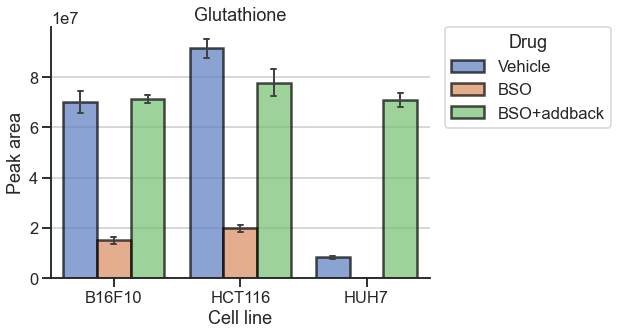

In [22]:
# Plotting for glutathione:
mask = (df_pos_flat['MW_RT_anno'] == '307.08374_9.842_GSH') & (df_pos_flat['Treatment'] != 'Cys') & (df_pos_flat['Treatment'] != 'Gln')
fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
g1.set_xlabel('Cell line')
g1.set_ylabel('Peak area')
g1.set_title('Glutathione')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug', loc='upper left')
sns.despine()
fig.tight_layout()

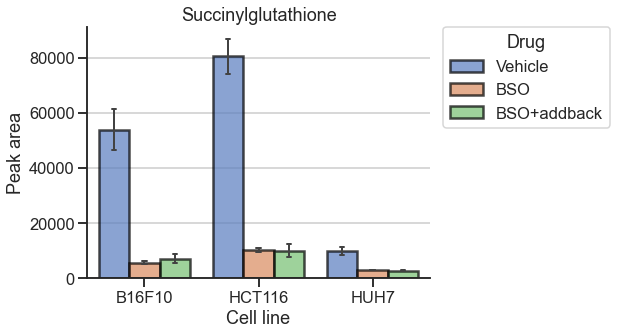

In [23]:
# Plotting for succinylglutathione:
mask = (df_pos_flat['MW_RT_anno'] == '423.09501_12.721_Succinylglutathione') & (df_pos_flat['Treatment'] != 'Cys') & (df_pos_flat['Treatment'] != 'Gln')
fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
g1.set_xlabel('Cell line')
g1.set_ylabel('Peak area')
g1.set_title('Succinylglutathione')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug', loc='upper left')
sns.despine()
fig.tight_layout()

An obvious in-source fragment of glutathione is when the peptide bond is broken to make cysteinylglycine.
Let's look at the characteristics of this.

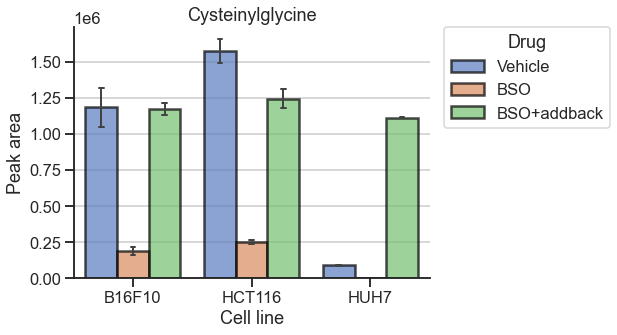

In [24]:
# Plotting for cysteinylglycine:
mask = (df_pos_flat['MW_RT_anno'] == '178.04131_9.848_Cysteinylglycine') & (df_pos_flat['Treatment'] != 'Cys') & (df_pos_flat['Treatment'] != 'Gln')
fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
g1.set_xlabel('Cell line')
g1.set_ylabel('Peak area')
g1.set_title('Cysteinylglycine')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug', loc='upper left')
sns.despine()
fig.tight_layout()

Notice also, that cysteinylglycine has almost the exact same retention time as glutathione.

This is an example of how the BSO control samples can be used to generate a list of ionization artifacts from in-source formation/fragmentation.
To flag these peaks in future results they can be blacklisted by adding them to 'resources/blacklist.tab'.

Below, I screen out these GSH ionization artifacts.

In [25]:
sample_grp = {
'B16F10':
    {
    'Vec': ['B16_vec_1', 'B16_vec_2'],
    'BSO': ['B16_BSO_1', 'B16_BSO_2'],
    'BSO+addback': ['B16_BSO_GSH-AB_1', 'B16_BSO_GSH-AB_2']
    },
'HCT116':
    {
    'Vec': ['HCT116_vec_1', 'HCT116_vec_2'],
    'BSO': ['HCT116_BSO_1', 'HCT116_BSO_2'],
    'BSO+addback': ['HCT116_BSO_GSH-AB_1', 'HCT116_BSO_GSH-AB_2']
    },
'HUH7':
    {
    'Vec': ['HUH7_vec_1', 'HUH7_vec_2'],
    'BSO': ['HUH7_BSO_1', 'HUH7_BSO_2'],
    'BSO+addback': ['HUH7_BSO_GSH-AB_1', 'HUH7_BSO_GSH-AB_2']
    }
}

In [26]:
def mask_GSH_artifacts(df_pol, sample_grp, plot_fld):
    fold_depl = 2
    mask_union = df_pol['pair_id'].isnull()
    for cell_line in sample_grp:
        vec_area = df_pol.loc[:, sample_grp[cell_line]['Vec']].mean(1)
        bso_area = df_pol.loc[:, sample_grp[cell_line]['BSO']].mean(1)
        ab_area = df_pol.loc[:, sample_grp[cell_line]['BSO+addback']].mean(1)

        mask = (vec_area / bso_area >= fold_depl) & (ab_area / bso_area >= fold_depl)
        mask_union = mask_union | mask

    mask_union = mask_union & (df_pol['RT_parent'] > (9.842-0.2)) & (df_pol['RT_parent'] < (9.842+0.2))
    print('Number of GSH ionization artifacts found: {}'.format(mask_union.sum()))
    
    # Plot all these, and dump the plots as pdf:
    _, df_pol_sele = flat_df(df_pol[mask_union], sample_info_df)
    for peak_pair in set(df_pol_sele['MW_RT_anno'].values):
        mask = (df_pol_sele['MW_RT_anno'] == peak_pair) & (df_pol_sele['Treatment'] != 'Cys') & (df_pol_sele['Treatment'] != 'Gln')
        fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
        g1 = sns.barplot(ax=ax1, data=df_pol_sele[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1);
        g1.set_xlabel('Cell line')
        g1.set_ylabel('Peak area')
        g1.set_title(peak_pair)
        g1.grid(True, axis='y')
        g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug', loc='upper left')
        sns.despine()
        fig.tight_layout();
        fig.savefig('{}/{}.pdf'.format(plot_fld, peak_pair), bbox_inches='tight');
        fig.clear();

    return(mask_union)

mask_union_pos = mask_GSH_artifacts(df_pos, sample_grp, 'projects/three-cell-lines/pos/plots/probable-GSH-artifacts')

Number of GSH ionization artifacts found: 25


<ipython-input-26-da4b895c1372>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))


<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

In [27]:
# Finally, add the newly found GSH artifacts to a new blacklist:
mask_union_no_known_pos = mask_union_pos & df_pos['known_anno'].isnull()
with open('resources/blacklist.tab', 'r') as bckl_old:
    with open('resources/blacklist-GSH-artifacts.tab', 'w') as bckl_new:
        for line in bckl_old:
            print(line, file=bckl_new, end='')
        for mw, rt in zip(df_pos.loc[mask_union_no_known_pos, 'MW_parent'].values, df_pos.loc[mask_union_no_known_pos, 'RT_parent'].values):
            print('\nInf. GSH artifact\t{}\t{}\tpos\t4\t0.5'.format(mw, rt), file=bckl_new, end='')

In [28]:
# Perform the same screen for negative polarity:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
df_neg, df_neg_flat = flat_df(df_neg, sample_info_df)
mask_union_neg = mask_GSH_artifacts(df_neg, sample_grp, 'projects/three-cell-lines/neg/plots/probable-GSH-artifacts')

# And add them to the new blacklist:
mask_union_no_known_neg = mask_union_neg & df_neg['known_anno'].isnull()
with open('resources/blacklist-GSH-artifacts.tab', 'a') as bckl_new:
    for mw, rt in zip(df_neg.loc[mask_union_no_known_neg, 'MW_parent'].values, df_neg.loc[mask_union_no_known_neg, 'RT_parent'].values):
        print('\nInf. GSH artifact\t{}\t{}\tneg\t4\t0.5'.format(mw, rt), file=bckl_new, end='')

Number of GSH ionization artifacts found: 20


<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

In [29]:
# And lastly, the peak pair tables can be updated:
peak_obj.flag_blacklist('resources/blacklist-GSH-artifacts.tab', polarity='both')

With the new filter, it gets easier to filter out noise.
Let us apply all the filters i.e. remove all adducts, isotopes and blacklisted peak pairs, and focusing on peak pairs that are labelled with both cystine and glutamine.

In [30]:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
mask = (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull() & df_pos['Label_set'] == 'cys, gln') | ~df_pos['known_anno'].isnull()
print('Peak pairs left after filtering: {}'.format(mask.sum()))
df_pos.loc[mask, ['MW_parent', 'RT_parent', 'Label_set', 'known_anno']]

Peak pairs left after filtering: 16


,MW_parent,RT_parent,Label_set,known_anno
0,121.02,8.626,cys,Cysteine
38,178.041,9.848,cys,Cysteinylglycine
45,191.025,10.435,cys,Conjugate EC = C3H3O2
46,193.041,7.601,cys,G3P Cys
70,237.031,11.885,cys,Succinylcysteine
99,283.073,9.323,cys,G6P Cys
113,307.084,9.842,"cys, gln",GSH
131,339.074,9.851,cys,Sulfinic glutathione
137,349.095,8.861,"cys, gln",S-(Formylmethyl)glutathione
153,379.105,9.143,"cys, gln",S-Lactoylglutathione


We see several compounds with peak pairs labelled by either cystine or cystine and glutamine as expected.
For example, glutathione (GSH), S-(Formylmethyl)glutathione, S-Lactoylglutathione, Succinylglutathione and oxidized glutathione (GSSG) is found labelled with both cystine and glutamine.
GSSG is represented by several rows because of in-source formation from GSH (as seen at retention time close to 9.9) and because cystine will label GSSG twice.

Cystine also trace into several cysteine conjugates e.g. G6P, G3P and Succinylcysteine.

The analysis is repeated in negative polarity below.

In [31]:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
mask = (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull() & df_neg['Label_set'] == 'cys, gln') | ~df_neg['known_anno'].isnull()
print('Peak pairs left after filtering: {}'.format(mask.sum()))
df_neg.loc[mask, ['MW_parent', 'RT_parent', 'Label_set', 'known_anno']]

Peak pairs left after filtering: 8


,MW_parent,RT_parent,Label_set,known_anno
6,178.041,6.819,cys,Cysteinylglycine
7,178.041,9.824,cys,Cysteinylglycine
12,191.025,10.391,cys,Conjugate EC = C3H3O2
27,237.031,11.889,cys,Succinylcysteine
41,283.073,9.317,cys,G6P Cys
50,307.084,9.819,"cys, gln",GSH
63,349.095,8.831,"cys, gln",S-(Formylmethyl)glutathione
87,423.096,12.715,cys,Succinylglutathione


Finally, let's check out the labelling of some of the compounds that are labelled by both cystine and glutamine.
Here shown for positive polarity.

In [32]:
# Data, no label:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
mask = (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull() & df_pos['Label_set'] == 'cys, gln') | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

# Data, cysteine label (m+4):
df_pos_m4 = peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].copy()
mask = (df_pos_m4['Isotopes'].isnull() & df_pos_m4['Adducts'].isnull() & df_pos_m4['Blacklist'].isnull() & df_pos_m4['Label_set'] == 'cys, gln') | ~df_pos_m4['known_anno'].isnull()
df_pos_m4, df_pos_flat_m4 = flat_df(df_pos_m4[mask], sample_info_df)

# Data, glutamine label (m+5):
df_pos_m5 = peak_obj.label_pairs['gln']['pos']['peak_pair_area_heavy'].copy()
mask = (df_pos_m5['Isotopes'].isnull() & df_pos_m5['Adducts'].isnull() & df_pos_m5['Blacklist'].isnull() & df_pos_m5['Label_set'] == 'cys, gln') | ~df_pos_m5['known_anno'].isnull()
df_pos_m5, df_pos_flat_m5 = flat_df(df_pos_m5[mask], sample_info_df)

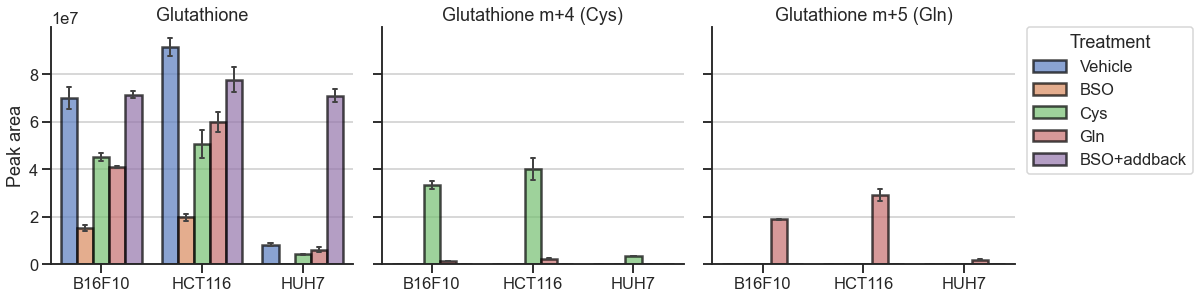

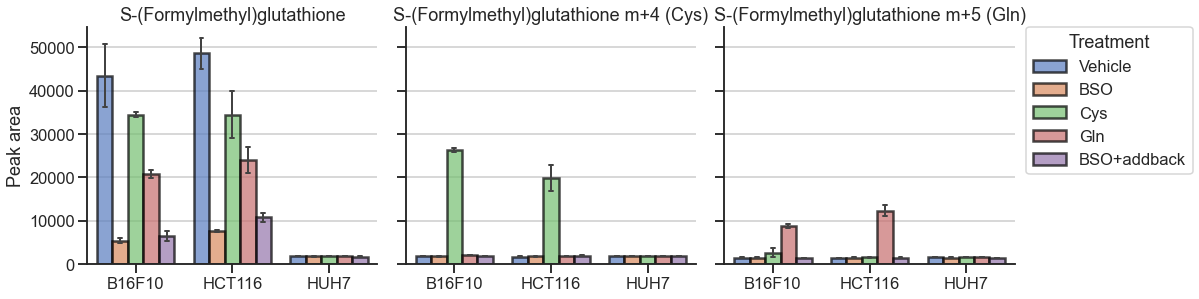

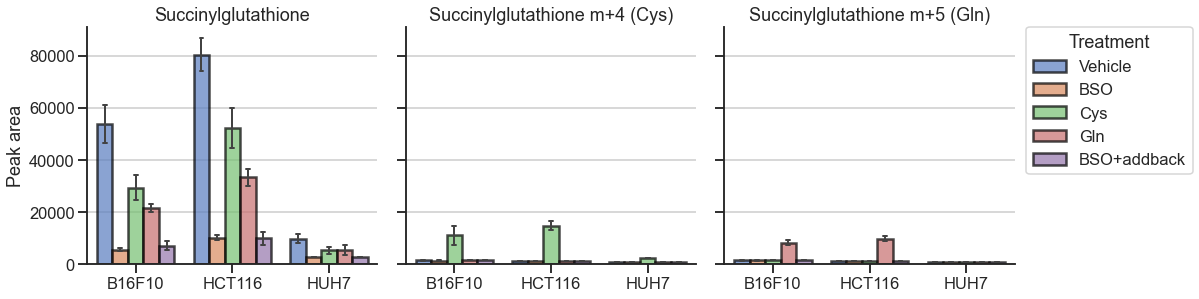

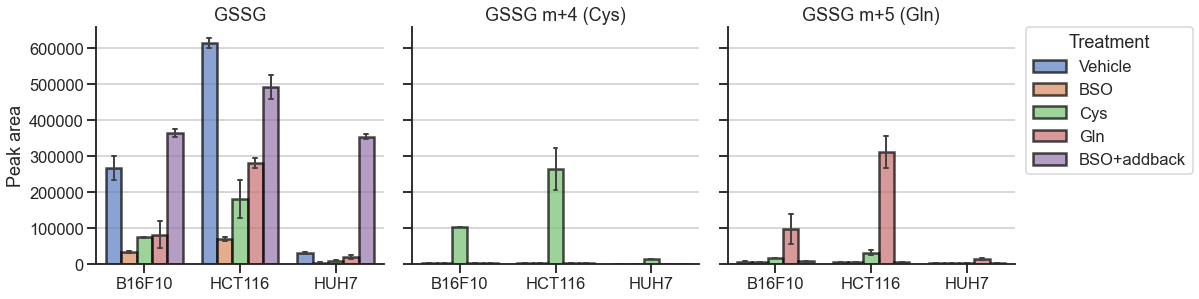

In [33]:
# Plotting:
for peak_id, name in zip(['307.08374_9.842_GSH', '349.09456_8.861_S-(Formylmethyl)glutathione', '423.09501_12.721_Succinylglutathione', '612.15316_11.932_GSSG'], ['Glutathione', 'S-(Formylmethyl)glutathione', 'Succinylglutathione', 'GSSG']):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id)
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id)
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.legend_.remove()

    ### Glutamine label (m+5):
    mask = (df_pos_flat_m5['MW_RT_anno'] == peak_id)
    g3 = sns.barplot(ax=ax3, data=df_pos_flat_m5[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g3.set_xlabel('')
    g3.set_ylabel('')
    g3.set_title('{} m+5 (Gln)'.format(name))
    g3.grid(True, axis='y')

    g3.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()